In [ ]:
!nvidia-smi
!yolo settings datasets_dir=/home/datasets

In [ ]:
import cv2
import os
import supervision as sv
from inference.models.yolo_world.yolo_world import YOLOWorld

# Define the folder containing your images
image_folder = "/home/datasets/images/"

# Load the model
model = YOLOWorld(model_id="yolo_world/l")
classes = ["chicken"]

# Create the bounding box annotator
bounding_box_annotator = sv.BoundingBoxAnnotator()

# Loop through each image in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".jpeg") or filename.endswith(".jpg"):  # You can add other image formats here if needed
        image_path = os.path.join(image_folder, filename)
        
        # Read the image
        image = cv2.imread(image_path)

        # Run the inference
        results = model.infer(image_path, text=classes, confidence=0.01)

        # Inspect the results to understand its structure
        print("Results:", results)  # Print results to understand the structure

        # Assuming `results` has a list-like or attribute-like structure
        # Access the detections (This might need adjustment based on the actual structure of the results)
        if hasattr(results, 'detections'):
            detections = results.detections
        else:
            # If detections are not found as an attribute, check if results return a list
            # e.g., If results[0] contains detections
            detections = sv.Detections.from_inference(results[0]) if isinstance(results, list) else None

        # If detections are found, proceed with annotation
        if detections is not None:
            # Annotate the bounding boxes on the image
            annotated_image = bounding_box_annotator.annotate(image, detections)

            # Optionally, save the annotated image
            output_path = os.path.join("/home/datasets/images/", f"annotated_{filename}")
            cv2.imwrite(output_path, annotated_image)

            # Display the image (optional)
            cv2.imshow(f"Annotated {filename}", annotated_image)
            cv2.waitKey(0)
        else:
            print(f"No detections found for {filename}")

cv2.destroyAllWindows()


In [ ]:
# Import necessary libraries
import os
import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor

# Ensure Jupyter Notebook prints outputs immediately
%load_ext autoreload
%autoreload 2

# === Setup ===

# Configuration
IMAGE_FOLDER = "/home/datasets/images/"  # Input folder containing images
OUTPUT_FOLDER = "/home/datasets/YOLOWorld/"  # Output folder for predictions and YOLO labels
YOLO_LABELS = ["", ""]  # Object classes to detect
EMBEDDING_PATH = "embeddings/custom_embeddings.npy"  # Path to embeddings

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Helper function to preprocess images
def preprocess_image(image_path, transform):
    """Load and preprocess an image."""
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)
    return input_tensor

# Helper function to save YOLO format labels
def save_yolo_labels(predictions, class_ids, confidences, image_width, image_height, label_output_path):
    """Save predictions in YOLO format."""
    with open(label_output_path, "w") as f:
        for box, class_id, confidence in zip(predictions, class_ids, confidences):
            # YOLO format: class_id x_center y_center width height (normalized)
            x_center = (box[0] + box[2]) / 2 / image_width
            y_center = (box[1] + box[3]) / 2 / image_height
            width = (box[2] - box[0]) / image_width
            height = (box[3] - box[1]) / image_height
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# === Install YOLOWorld (Optional) ===
!git clone --recursive https://github.com/AILab-CVC/YOLO-World.git
!pip install -r YOLO-World/requirements.txt
!pip install -e YOLO-World

# Add YOLOWorld to the Python path
import sys
sys.path.append('/path/to/YOLO-World')

# === Load YOLOWorld Model ===
from yoloworld.models.simple_yolo import SimpleYOLOWorldDetector
from clip import clip

# Step 1: Generate embeddings
if not os.path.exists(EMBEDDING_PATH):
    print("Generating embeddings...")
    model_clip, preprocess_clip = clip.load("ViT-B/32")
    text_tokens = clip.tokenize(YOLO_LABELS)
    with torch.no_grad():
        text_features = model_clip.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    os.makedirs(os.path.dirname(EMBEDDING_PATH), exist_ok=True)
    torch.save(text_features.cpu().numpy(), EMBEDDING_PATH)

# Step 2: Initialize YOLOWorld
print("Loading YOLOWorld model...")
model = SimpleYOLOWorldDetector(
    mm_neck=True,
    num_train_classes=len(YOLO_LABELS),
    num_test_classes=len(YOLO_LABELS),
    embedding_path=EMBEDDING_PATH,
)
model.eval()

# Step 3: Define transformation for input images
transform = Compose([Resize((640, 640)), ToTensor()])

# === Detection Loop ===
print("Processing images...")
for image_name in os.listdir(IMAGE_FOLDER):
    if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        # File paths
        image_path = os.path.join(IMAGE_FOLDER, image_name)
        label_output_path = os.path.join(OUTPUT_FOLDER, f"{os.path.splitext(image_name)[0]}.txt")

        # Preprocess the image
        input_tensor = preprocess_image(image_path, transform)

        # Predict bounding boxes and classes
        with torch.no_grad():
            outputs = model(input_tensor)

        # Parse model outputs (mock example: adjust for actual output format)
        predictions = outputs["boxes"]  # Bounding boxes
        class_ids = outputs["labels"]  # Class IDs
        confidences = outputs["scores"]  # Confidence scores

        # Save YOLO format labels
        save_yolo_labels(predictions, class_ids, confidences, 640, 640, label_output_path)
        print(f"Processed {image_name}, labels saved to {label_output_path}")

print("Processing complete. Outputs saved to:", OUTPUT_FOLDER)


In [ ]:
import os
from ultralytics import YOLO
from PIL import Image, ImageDraw

# Initialize the YOLO model
model = YOLO("/home/weights/best.pt")

# Define custom classes
model.set_classes(["Feeding", "Foraging"])

# Input and output directories
image_dir = "/home/images/test"
output_image_dir = "/home/Outputimages/"
output_labels_dir = "/home/Outputlabels/"

# Make sure the output directories exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Execute prediction for specified categories on an image
results = model.predict(image_dir)

# Process the results and save the labeled images and YOLO .txt files
for i, result in enumerate(results):
    # Process each image
    img_path = result.path
    img_name = os.path.basename(img_path)
    image = Image.open(img_path).convert("RGB")  # Open the image in RGB format
    
    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(image)
    
    # List to hold YOLO formatted labels
    yolo_labels = []
    
    # Loop through the detections for this image
    for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        # Extract bounding box coordinates and class information
        x1, y1, x2, y2 = box
        class_id = int(cls)
        confidence = conf.item()
        class_name = model.names[class_id]
        
        # Draw the bounding box and class label on the image
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=3)
        draw.text((x1, y1 - 10), f"{class_name}: {confidence:.2f}", fill="blue")

        # Convert the bounding box to YOLO format: <class_id> <x_center> <y_center> <width> <height>
        x_center = (x1 + x2) / 2 / image.width
        y_center = (y1 + y2) / 2 / image.height
        width = (x2 - x1) / image.width
        height = (y2 - y1) / image.height
        
        # Append YOLO label (class_id, x_center, y_center, width, height)
        yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Save the output image with bounding boxes
    output_image_path = os.path.join(output_image_dir, f"labeled_{img_name}")
    image.save(output_image_path)

    # Save YOLO-format labels to text file
    output_label_path = os.path.join(output_labels_dir, f"{os.path.splitext(img_name)[0]}.txt")
    with open(output_label_path, 'w') as label_file:
        for label in yolo_labels:
            label_file.write(label + "\n")
    
    print(f"Processed {img_name} - Saved labeled image and YOLO labels.")

print("Processing complete. All labeled images and YOLO labels have been saved.")


In [ ]:
import os
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont

# Initialize the YOLO model
model = YOLO("/home/weights/best.pt")

# Define custom classes
model.set_classes(["Feeding", "Foraging", "", "", "", "", "", "", "", "", ""])

# Input and output directories
image_dir = "/home/images/"
output_image_dir = "/home/Outputimages2/"
output_labels_dir = "/home/Outputlabels2/"

# Make sure the output directories exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Define class colors
class_colors = {
    "Dustbathing": (255, 0, 0),    # Red for Feeding
    "Drinking": (0, 0, 255),   # Blue for Foraging
    "Perching": (0, 255, 0
}

# Load the Times New Roman font with size 24
font_path = "/home/rbist/ttf/Times_New_Roman.ttf"  # Adjust the path if needed
font = ImageFont.truetype(font_path, 24)  # Font size 24

# Execute prediction for specified categories on an image
results = model.predict(image_dir)

# Process the results and save the labeled images and YOLO .txt files
for i, result in enumerate(results):
    # Process each image
    img_path = result.path
    img_name = os.path.basename(img_path)
    image = Image.open(img_path).convert("RGB")  # Open the image in RGB format
    
    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(image)
    
    # List to hold YOLO formatted labels
    yolo_labels = []
    
    # Loop through the detections for this image
    for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        # Extract bounding box coordinates and class information
        x1, y1, x2, y2 = box
        class_id = int(cls)
        confidence = conf.item()
        class_name = model.names[class_id]
        
        # Get color for the class
        class_color = class_colors.get(class_name, (255, 255, 255))  # Default to white if class not found
        
        # Draw the bounding box
        draw.rectangle([x1, y1, x2, y2], outline=class_color, width=3)

        # Calculate text and its size
        text = f"{class_name}: {confidence:.2f}"
        
        # Using textbbox to get the bounding box of the text
        text_bbox = draw.textbbox((x1, y1), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Position the text just above the bounding box, aligned to the right
        text_x = x2 - text_width  # Align text to the right edge of the bounding box
        text_y = y1 - text_height - 5  # Position the text just above the bounding box

        # Draw the text on the image
        draw.text((text_x, text_y), text, fill=class_color, font=font)

        # Convert the bounding box to YOLO format: <class_id> <x_center> <y_center> <width> <height>
        x_center = (x1 + x2) / 2 / image.width
        y_center = (y1 + y2) / 2 / image.height
        width = (x2 - x1) / image.width
        height = (y2 - y1) / image.height
        
        # Append YOLO label (class_id, x_center, y_center, width, height)
        yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Save the output image with bounding boxes
    output_image_path = os.path.join(output_image_dir, f"labeled_{img_name}")
    image.save(output_image_path)

    # Save YOLO-format labels to text file
    output_label_path = os.path.join(output_labels_dir, f"{os.path.splitext(img_name)[0]}.txt")
    with open(output_label_path, 'w') as label_file:
        for label in yolo_labels:
            label_file.write(label + "\n")
    
    print(f"Processed {img_name} - Saved labeled image and YOLO labels.")

print("Processing complete. All labeled images and YOLO labels have been saved.")


In [ ]:
#Video Based detection
import os
import cv2
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# Initialize the YOLO model
model = YOLO("/home/weights/best.pt")

# Define the 11 standard attractive colors for the behaviors
standard_colors = [
    (255, 0, 0),      # Red
    (0, 0, 255),      # Blue
    (0, 255, 0),      # Green
    (255, 165, 0),    # Orange
    (128, 0, 128),    # Purple
    (255, 255, 0),    # Yellow
    (0, 255, 255),    # Cyan
    (255, 0, 255),    # Magenta
    (0, 0, 139),      # Dark Blue
    (0, 255, 0),      # Lime
    (0, 128, 128),    # Teal
]

# Define behavior classes and their corresponding colors
behavior_class_colors = {
    "Feeding": standard_colors[0],
    "Foraging": standard_colors[1],
    "": standard_colors[2],
    "": standard_colors[3],
    "": standard_colors[4],
    "": standard_colors[5],
    "": standard_colors[6],
    "": standard_colors[7],
    "": standard_colors[8],
    "": standard_colors[9],
    "": standard_colors[10],
}

# Load the Times New Roman font with size 24
font_path = "/home/ttf/Times_New_Roman.ttf"  # Adjust the path if needed
font = ImageFont.truetype(font_path, 24)  # Font size 24

# Define a function to filter the results based on the text prompt
def filter_classes_by_prompt(prompt):
    available_classes = [
        "Feeding", "Foraging", "", "", "", 
        "", "", "", "", "", ""
    ]
    # Return a list of behaviors that match the user's prompt (case-insensitive)
    return [cls for cls in available_classes if prompt.lower() in cls.lower()]

# Example: prompt can be any string, like "Feeding" or "Dustbathing"
prompt = ""  # Replace with the behavior you want to detect

# Filter out behaviors that match the prompt
filtered_classes = filter_classes_by_prompt(prompt)

# Input video path and output video path
input_video_path = "/home/videos/test_video.mp4"
output_video_path = "/home/OutputVideo.avi"

# Open the input video
cap = cv2.VideoCapture(input_video_path)

# Get the video properties (frame width, height, and frames per second)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create a VideoWriter object to save the processed video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Convert the frame to a PIL image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(pil_image)
    
    # List to hold YOLO formatted labels
    yolo_labels = []
    
    # Run YOLO model on the frame (which is a PIL image)
    results = model(pil_image)
    
    for result in results:
        for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
            # Extract bounding box coordinates and class information
            x1, y1, x2, y2 = box
            class_id = int(cls)
            confidence = conf.item()
            class_name = model.names[class_id]
            
            # Only process detections for filtered classes
            if class_name not in filtered_classes:
                continue
            
            # Get color for the class
            class_color = behavior_class_colors.get(class_name, (255, 255, 255))  # Default to white if class not found
            
            # Draw the bounding box
            draw.rectangle([x1, y1, x2, y2], outline=class_color, width=3)

            # Calculate text and its size
            text = f"{class_name}: {confidence:.2f}"
            
            # Using textbbox to get the bounding box of the text
            text_bbox = draw.textbbox((x1, y1), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            # Position the text just above the bounding box, aligned to the right
            text_x = x2 - text_width  # Align text to the right edge of the bounding box
            text_y = y1 - text_height - 5  # Position the text just above the bounding box

            # Draw the text on the image
            draw.text((text_x, text_y), text, fill=class_color, font=font)
    
    # Convert the PIL image back to a frame (OpenCV format)
    frame_with_boxes = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    
    # Write the frame to the output video
    out.write(frame_with_boxes)

# Release the video capture and writer objects
cap.release()
out.release()

print("Processing complete. The video with bounding boxes has been saved.")


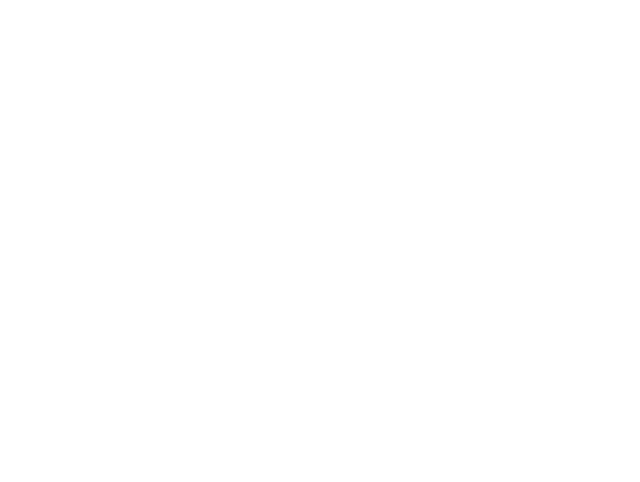

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Initialize the YOLO model
model = YOLO("/home/weights/best.pt")

# Define the 11 standard attractive colors for the behaviors
standard_colors = [
    (255, 0, 0), (0, 0, 255), (0, 255, 0), (255, 165, 0), 
    (128, 0, 128), (255, 255, 0), (0, 255, 255), (255, 0, 255), 
    (0, 0, 139), (0, 255, 0), (0, 128, 128)
]

# Define behavior classes and their corresponding colors
behavior_class_colors = {
    "Feeding": standard_colors[0],
    "Foraging": standard_colors[1],
    "": standard_colors[2],
    "": standard_colors[3],
    "": standard_colors[4],
    "": standard_colors[5],
    "": standard_colors[6],
    "": standard_colors[7],
    "": standard_colors[8],
    "": standard_colors[9],
    "": standard_colors[10],
}

# Load the font for labeling
font_path = "/home/ttf/Times_New_Roman.ttf"
font = ImageFont.truetype(font_path, 24)

# Function to filter classes by text prompt
def filter_classes_by_prompt(prompt):
    available_classes = [
        "Feeding", "Foraging", "", "", "", 
        "", "", "", "", "", ""
    ]
    if isinstance(prompt, str):
        prompt = [prompt]
    return [cls for cls in available_classes if any(p.lower() in cls.lower() for p in prompt)]

# Set the text prompt
prompt = ["Perching"]
filtered_classes = filter_classes_by_prompt(prompt)

# Open the video file or webcam stream
video_path = "/home/BH.mp4"  # Replace with your video path or 0 for webcam
cap = cv2.VideoCapture(video_path)

# Set up matplotlib for inline video display
plt.ion()  # Turn interactive mode on
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')  # Hide axes

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Run YOLO model on the frame
        results = model.predict(frame)

        # Draw detections on the frame
        draw = ImageDraw.Draw(image)
        for box, cls, conf in zip(results[0].boxes.xyxy, results[0].boxes.cls, results[0].boxes.conf):
            x1, y1, x2, y2 = map(int, box)
            class_id = int(cls)
            confidence = conf.item()
            class_name = model.names[class_id]

            # Filter detections based on the prompt
            if class_name not in filtered_classes:
                continue

            # Draw bounding box
            color = behavior_class_colors.get(class_name, (255, 255, 255))
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)

            # Add label
            label = f"{class_name} {confidence:.2f}"
            text_bbox = draw.textbbox((x1, y1), label, font=font)
            text_x, text_y = text_bbox[:2]
            draw.text((text_x, text_y - 10), label, fill=color, font=font)

        # Convert PIL image back to OpenCV format for display
        frame_rgb = np.array(image)

        # Display the frame using matplotlib
        ax.imshow(frame_rgb)
        plt.draw()  # Update the figure with the new frame
        plt.pause(0.01)  # Pause for 10ms to update the figure

except KeyboardInterrupt:
    print("Stopped by user.")

finally:
    # Release resources
    cap.release()
    plt.ioff()  # Turn off interactive mode
    plt.show()  # Show the final figure after the loop finishes


In [ ]:
#Image based detection

import os
import cv2
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont

# Initialize the YOLO model
model = YOLO("/home/weights/best.pt")

# Define the 11 standard attractive colors for the behaviors
standard_colors = [
    (255, 0, 0),      # Red
    (0, 0, 255),      # Blue
    (0, 255, 0),      # Green
    (255, 165, 0),    # Orange
    (128, 0, 128),    # Purple
    (255, 255, 0),    # Yellow
    (0, 255, 255),    # Cyan
    (255, 0, 255),    # Magenta
    (0, 0, 139),      # Dark Blue
    (0, 255, 0),      # Lime
    (0, 128, 128),    # Teal
]

# Define behavior classes and their corresponding colors
behavior_class_colors = {
    "Feeding": standard_colors[0],
    "Foraging": standard_colors[1],
    "": standard_colors[2],
    "": standard_colors[3],
    "": standard_colors[4],
    "": standard_colors[5],
    "": standard_colors[6],
    "": standard_colors[7],
    "": standard_colors[8],
    "": standard_colors[9],
    "": standard_colors[10],
}

# Input and output directories
image_dir = "/home/images/"
output_image_dir = "/home/Predictedimages1/"
output_labels_dir = "/home/Predictedlabels1/"

# Make sure the output directories exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Load the Times New Roman font with size 24
font_path = "/home/ttf/Times_New_Roman.ttf"  # Adjust the path if needed
font = ImageFont.truetype(font_path, 24)  # Font size 24

# Define a function to filter the results based on the text prompt
def filter_classes_by_prompt(prompt):
    available_classes = [
        "Feeding", "Foraging", "", "", "", 
        "", "", "", "", "", ""
    ]
    # Return a list of behaviors that match the user's prompt (case-insensitive)
    # Prompt can be a string or a list of strings
    if isinstance(prompt, str):
        prompt = [prompt]
    
    return [cls for cls in available_classes if any(p.lower() in cls.lower() for p in prompt)]

# Example: prompt can be a single string or a list of strings
prompt = ["Feeding", "Foraging", "", "", "", "", "", "", "", "", ""]  # Replace with the behaviors you want to detect

# Filter out behaviors that match the prompt
filtered_classes = filter_classes_by_prompt(prompt)

# Execute prediction for specified categories on an image
results = model.predict(image_dir)

# Process the results and save the labeled images and YOLO .txt files
for i, result in enumerate(results):
    # Process each image
    img_path = result.path
    img_name = os.path.basename(img_path)
    image = Image.open(img_path).convert("RGB")  # Open the image in RGB format
    
    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(image)
    
    # List to hold YOLO formatted labels
    yolo_labels = []
    
    # Loop through the detections for this image
    for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        # Extract bounding box coordinates and class information
        x1, y1, x2, y2 = box
        class_id = int(cls)
        confidence = conf.item()
        class_name = model.names[class_id]
        
        # Only process detections for filtered classes
        if class_name not in filtered_classes:
            continue
        
        # Get color for the class
        class_color = behavior_class_colors.get(class_name, (255, 255, 255))  # Default to white if class not found
        
        # Draw the bounding box
        draw.rectangle([x1, y1, x2, y2], outline=class_color, width=3)

        # Calculate text and its size
        text = f"{class_name}: {confidence:.2f}"
        
        # Using textbbox to get the bounding box of the text
        text_bbox = draw.textbbox((x1, y1), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Position the text just above the bounding box, aligned to the right
        text_x = x2 - text_width  # Align text to the right edge of the bounding box
        text_y = y1 - text_height - 5  # Position the text just above the bounding box

        # Draw the text on the image
        draw.text((text_x, text_y), text, fill=class_color, font=font)

        # Convert the bounding box to YOLO format: <class_id> <x_center> <y_center> <width> <height>
        x_center = (x1 + x2) / 2 / image.width
        y_center = (y1 + y2) / 2 / image.height
        width = (x2 - x1) / image.width
        height = (y2 - y1) / image.height
        
        # Append YOLO label (class_id, x_center, y_center, width, height)
        yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Save the output image with bounding boxes
    output_image_path = os.path.join(output_image_dir, f"labeled_{img_name}")
    image.save(output_image_path)

    # Save YOLO-format labels to text file
    output_label_path = os.path.join(output_labels_dir, f"{os.path.splitext(img_name)[0]}.txt")
    with open(output_label_path, 'w') as label_file:
        for label in yolo_labels:
            label_file.write(label + "\n")
    
    print(f"Processed {img_name} - Saved labeled image and YOLO labels.")

print("Processing complete. All labeled images and YOLO labels have been saved.")



In [ ]:
# Image-based behavior detection using YOLO with confidence filtering

import os
import cv2
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont

# Load the YOLO model
model = YOLO("/home/weights/best.pt")

# Define 11 standard colors for different behaviors
standard_colors = [
    (255, 0, 0),      # Red
    (0, 0, 255),      # Blue
    (0, 255, 0),      # Green
    (255, 165, 0),    # Orange
    (128, 0, 128),    # Purple
    (255, 255, 0),    # Yellow
    (0, 255, 255),    # Cyan
    (255, 0, 255),    # Magenta
    (0, 0, 139),      # Dark Blue
    (0, 255, 0),      # Lime
    (0, 128, 128),    # Teal
]

# Mapping of class names to colors
behavior_class_colors = {
    "Feeding": standard_colors[0],
    "Foraging": standard_colors[1],
    "": standard_colors[2],
    "": standard_colors[3],
    "": standard_colors[4],
    "": standard_colors[5],
    "": standard_colors[6],
    "": standard_colors[7],
    "": standard_colors[8],
    "": standard_colors[9],
    "": standard_colors[10],
}

# Directories
image_dir = "/home/images/"
output_image_dir = "/home/Predictedimages2/"
output_labels_dir = "/home/Predictedlabels2/"

# Create output directories if they don't exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Load font
font_path = "/home/rbist/ttf/Times_New_Roman.ttf"
font = ImageFont.truetype(font_path, 24)

# Filter prompt
def filter_classes_by_prompt(prompt):
    all_classes = list(behavior_class_colors.keys())
    if isinstance(prompt, str):
        prompt = [prompt]
    return [cls for cls in all_classes if any(p.lower() in cls.lower() for p in prompt)]

# Behavior prompt: choose what you want to detect
prompt = ["Feeding", "Foraging", "", "", "", "", "", "", "", "", ""]
filtered_classes = filter_classes_by_prompt(prompt)

# Run inference with confidence threshold of 0.5
results = model.predict(source=image_dir, conf=0.5)

# Process each image result
for result in results:
    img_path = result.path
    img_name = os.path.basename(img_path)
    image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    yolo_labels = []

    for box, cls, conf in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.conf):
        x1, y1, x2, y2 = box
        class_id = int(cls)
        confidence = conf.item()
        class_name = model.names[class_id]

        # Filter only desired behaviors
        if class_name not in filtered_classes:
            continue

        color = behavior_class_colors.get(class_name, (255, 255, 255))
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)

        # Label text
        text = f"{class_name}: {confidence:.2f}"
        text_bbox = draw.textbbox((x1, y1), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        text_x = x2 - text_width
        text_y = y1 - text_height - 5
        draw.text((text_x, text_y), text, fill=color, font=font)

        # Convert to YOLO format
        x_center = (x1 + x2) / 2 / image.width
        y_center = (y1 + y2) / 2 / image.height
        width = (x2 - x1) / image.width
        height = (y2 - y1) / image.height
        yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Save labeled image
    image.save(os.path.join(output_image_dir, f"labeled_{img_name}"))

    # Save YOLO label
    label_file_path = os.path.join(output_labels_dir, f"{os.path.splitext(img_name)[0]}.txt")
    with open(label_file_path, 'w') as f:
        for label in yolo_labels:
            f.write(label + "\n")

    print(f"✅ Processed {img_name} — labels and image saved.")

print("\n🎉 Done! All images processed with confidence ≥ 0.50.")
